In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

In [4]:
data1 = pd.read_csv('data_01.csv')
data2 = pd.read_csv('data_02.csv')
data3 = pd.read_csv('data_03.csv')
data4 = pd.read_csv('data_04.csv')
data5 = pd.read_csv('data_05.csv')
data6 = pd.read_csv('data_06.csv')

In [5]:
data = [data1,data2,data3,data4,data5,data6]

In [6]:
df = pd.concat(data)

In [7]:
lens=[]
for df in data:
    lens.append(len(df))

In [8]:
lens

[55, 50, 55, 53, 47, 2]

In [9]:
indices = []
for i, count in enumerate(lens):
    for _ in range(count):
        indices.append(i)

In [11]:
dfs = [data1,data2,data3,data4,data5,data6]
lens = [data[i].shape[0] for i in range(len(data))]
indices = []
for i, count in enumerate(lens):
      for _ in range(count):
        indices.append(i)

df = pd.concat(dfs)
x = df['x']
y = df['y']

In [ ]:
N = len(df)
M = 6
idx = np.repeat(range(M-1), N)
idx = np.append(idx,5)
idx = np.append(idx,5)
np.random.seed(42)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

x_m = df['x']
y_m = df['y']

_, ax = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

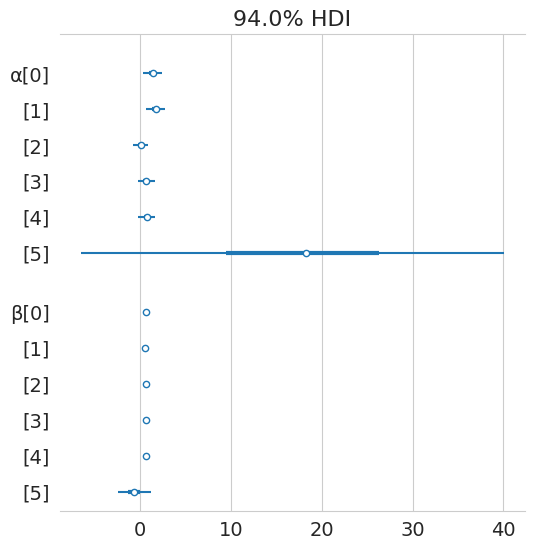

In [12]:
M = 6

x_centered = x - x.mean()

with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10, shape=M)
    β = pm.Normal('β', mu=0, sigma=10, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[indices] + β[indices] * x_centered,
                         sigma=ε, nu=ν, observed=y)

    α = pm.Deterministic('α', α_tmp - β * x.mean())

    trace_up = pm.sample(2000, idata_kwargs={"log_likelihood": True})
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True);

In [13]:
len(indices)

262

In [14]:
len(idx)

12

In [15]:
len(idx)

12

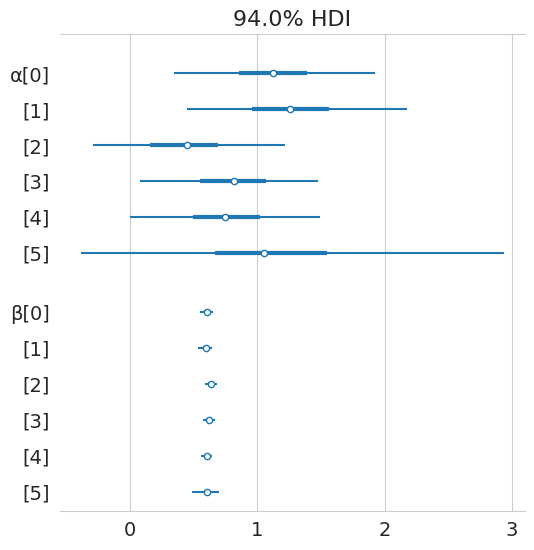

In [16]:
with pm.Model() as hierarchical_model:
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=10)
    β_μ = pm.Normal('β_μ', mu=0, sigma=1)
    β_σ = pm.HalfNormal('β_σ', sigma=1)

    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[indices] + β[indices] * x_centered,
                         sigma=ε, nu=ν, observed=y)

    α = pm.Deterministic('α', α_tmp - β * x.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x.mean())

    trace_hm = pm.sample(3000,tune = 1000, idata_kwargs={"log_likelihood": True})

az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);

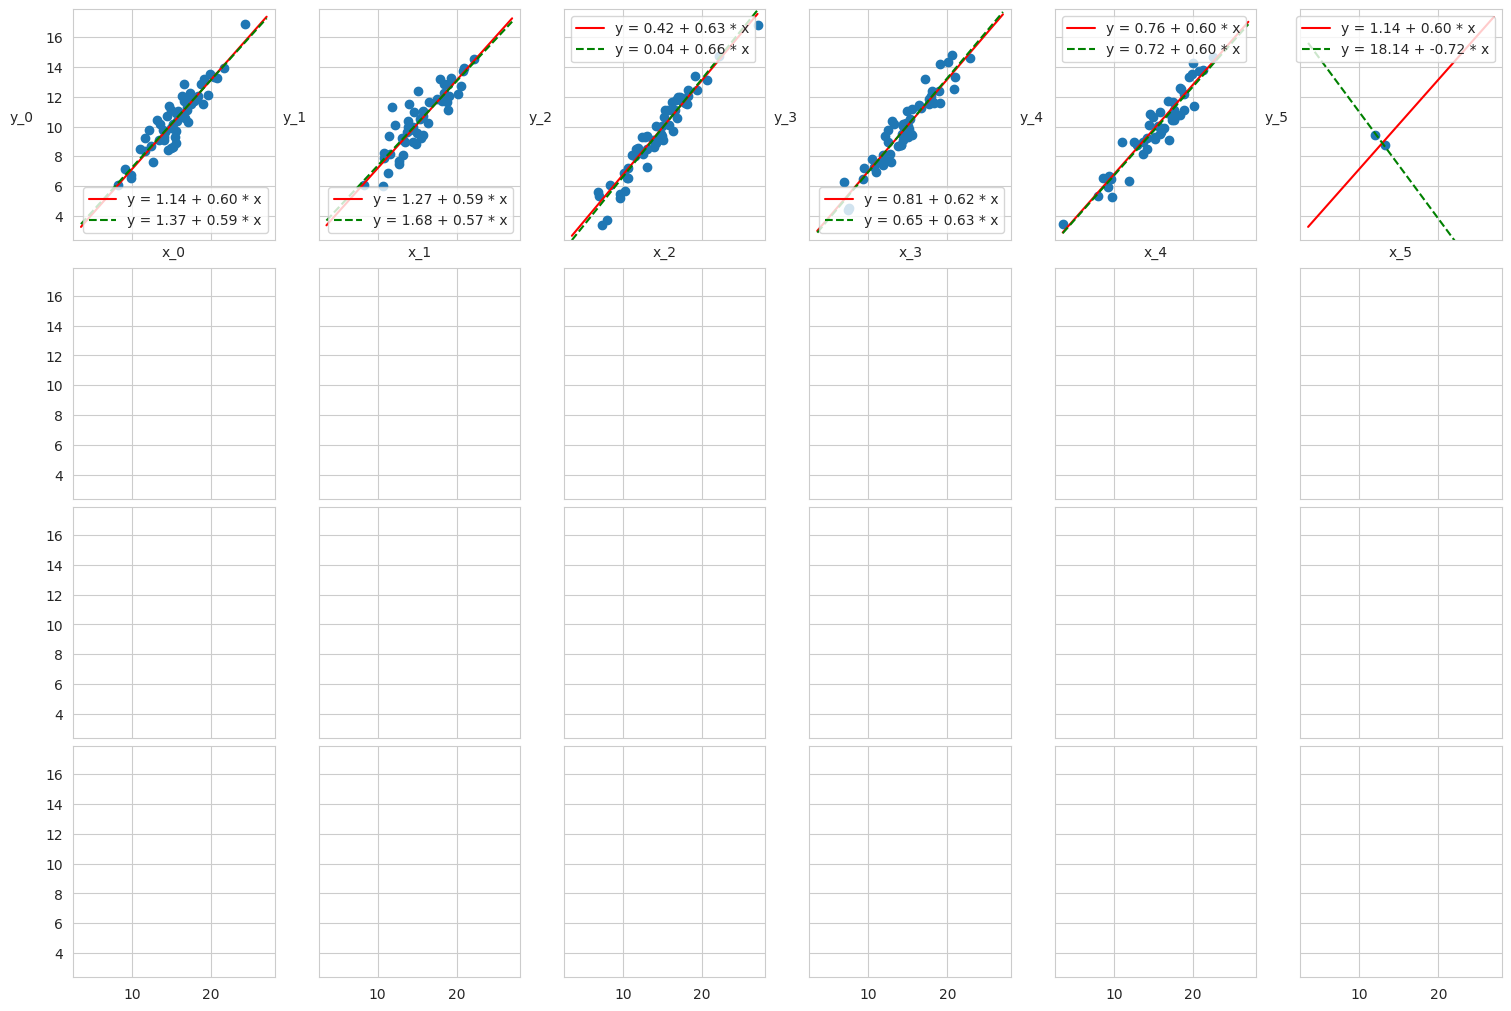

In [21]:
_, ax = plt.subplots(4, 6, figsize=(15, 10), sharex=True, sharey=True,
                     constrained_layout=True)

trace_hmm = trace_hm.posterior.stack(samples={"chain", "draw"})
trace_upp = trace_up.posterior.stack(samples={"chain", "draw"})


ax = np.ravel(ax)
j, k = 0, indices.count(0)
x_range = np.linspace(x.min(), x.max(), 10)

for i in range(M):
    ax[i].scatter(x[j:k], y[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hmm['α'].sel({'α_dim_0':i}).mean().item()
    beta_m  = trace_hmm['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='r',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

    alpha_o = trace_upp['α'].sel({'α_dim_0':i}).mean().item()
    beta_o = trace_upp['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_o + beta_o * x_range, 'g--',
               label=f'y = {alpha_o:.2f} + {beta_o:.2f} * x')

    ax[i].legend()
    plt.xlim(x.min()-1, x.max()+1)
    plt.ylim(y.min()-1, y.max()+1)
    j += indices.count(i)
    k += indices.count(i + 1)

In [18]:
display(az.summary(trace_up,var_names=['α', 'β']))
display(az.summary(trace_hm,var_names=['α', 'β']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],1.371,0.573,0.324,2.427,0.008,0.006,5291.0,3031.0,1.0
α[1],1.676,0.581,0.588,2.752,0.009,0.006,4443.0,3070.0,1.0
α[2],0.045,0.436,-0.811,0.832,0.005,0.007,6501.0,2772.0,1.0
α[3],0.645,0.482,-0.295,1.562,0.006,0.006,6736.0,2763.0,1.0
α[4],0.720,0.479,-0.246,1.582,0.007,0.006,4917.0,2781.0,1.0
α[5],18.142,12.522,-6.539,40.042,0.255,0.180,2413.0,2625.0,1.0
β[0],0.588,0.036,0.521,0.652,0.000,0.000,5587.0,2935.0,1.0
β[1],0.569,0.037,0.500,0.636,0.001,0.000,4693.0,3077.0,1.0
β[2],0.658,0.029,0.603,0.713,0.000,0.000,6075.0,2903.0,1.0
β[3],0.631,0.032,0.571,0.692,0.000,0.000,6145.0,2859.0,1.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],1.136,0.417,0.345,1.923,0.013,0.009,916.0,3489.0,1.01
α[1],1.274,0.467,0.451,2.173,0.014,0.010,1022.0,1698.0,1.01
α[2],0.421,0.410,-0.291,1.216,0.025,0.027,242.0,89.0,1.01
α[3],0.806,0.381,0.075,1.476,0.017,0.012,489.0,2433.0,1.00
α[4],0.756,0.400,0.003,1.494,0.014,0.011,872.0,2298.0,1.01
α[5],1.139,0.879,-0.385,2.936,0.019,0.015,2020.0,2021.0,1.00
β[0],0.601,0.026,0.550,0.650,0.001,0.001,1065.0,3211.0,1.00
β[1],0.592,0.029,0.538,0.646,0.001,0.001,974.0,2861.0,1.01
β[2],0.635,0.027,0.587,0.684,0.001,0.001,282.0,107.0,1.01
β[3],0.619,0.025,0.576,0.667,0.001,0.001,743.0,3318.0,1.00
